In [23]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

#importing helper functions for pre-processing data
from util import cleaning_data, stemming, wordcloud

In [24]:
# cleanine_data function loads in data, adds labels, removes all punctuation, digits & stop words 
data = cleaning_data("data/true.csv", "data/fake.csv")

/Users/oleksandrafilippova/ML_class/final_project/nlp_project_yas/util.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = true_df.append(fake_df).sample(frac=1).reset_index().drop(columns=['index'])


Example of the dataset `data` consisting of both labels(1 is True, 0 is Fake):

In [25]:
data

,text,target
0,britain germany agreed sunday remained committ...,1
1,chicago residents living nightmare murder crim...,0
2,senator john mccain got outed hypocrite damnin...,0
3,indian prime minister narendra modi final phas...,1
4,allegations russia breaking cold war era inter...,1
...,...,...
44893,president donald trump pressed unproven claims...,1
44894,newsweek magazine gone completely overboard la...,0
44895,highly anticipated declassified us intelligenc...,0
44896,house intelligence committee disclose wednesda...,1


In [26]:
print('distribution of word frequencies before stemming: ')
pd.Series(' '.join(data.text).split()).value_counts().describe()

distribution of word frequencies before stemming: 


count    110114.000000
mean         94.090243
std         922.111957
min           1.000000
25%           1.000000
50%           3.000000
75%          13.000000
max      134043.000000
dtype: float64

In [28]:
print('top 10 words before stemming are: ')
pd.Series(' '.join(data.text).split()).value_counts()[:10]

top 10 words before stemming are: 


trump        134043
said         132816
president     55895
would         55165
people        41857
one           37892
state         34490
also          31357
new           30312
clinton       28700
dtype: int64

In [29]:
print('top 10 words in true articles before stemming are: ')
pd.Series(' '.join(data[data.target == 0].text).split()).value_counts()[:10]

top 10 words in true articles before stemming are: 


trump        79349
said         33763
president    27720
people       26572
one          24531
would        23562
clinton      19179
obama        18798
like         18097
donald       17671
dtype: int64

In [30]:
print('top 10 words in false articles before stemming are: ')
pd.Series(' '.join(data[data.target == 1].text).split()).value_counts()[:10]

top 10 words in false articles before stemming are: 


said          99053
trump         54694
would         31603
president     28175
state         21023
government    18846
states        16651
house         16635
republican    16241
also          15954
dtype: int64

Cloud of words for the entire dataset:


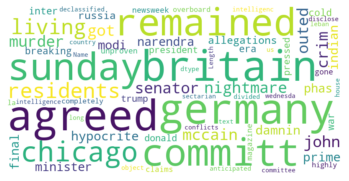

Cloud of words for false articles:


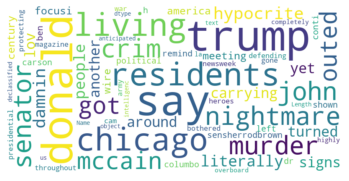

Cloud of words for true articles:


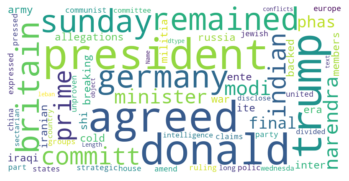

In [31]:
%matplotlib inline
print('Cloud of words for the entire dataset:')
wordcloud(data.text, 100)

print('Cloud of words for false articles:')
wordcloud(data[data.target == 0].text, 100)

print('Cloud of words for true articles:')
wordcloud(data[data.target == 1].text, 100)

## From the descriptive statistics above: 

- The dataset consists `110,114` unique words after stop words (i.e., *you*, *she*, *and*).
- The median frequency among all words equals to `3`. Meaning, at least a half of all words were mentioned once, twice or three times in the entire dataset.
- The word that was mentioned the most is `trump`. It was mentioned ` 134,043` times. 

Having `110,114` features for a `40,000`-observation dataset we are risking to encounter **Curse of Dimensionality**. We need to reduce the number of total features before training the model.

In [7]:
data['text'] = stemming(data['text'])

In [8]:
print('distribution of stems frequencies after stemming: ')
pd.Series(' '.join(data['text']).split()).value_counts().describe()

distribution of stems frequencies after stemming: 


count     84331.000000
mean        122.856992
std        1197.953563
min           1.000000
25%           1.000000
50%           2.000000
75%           9.000000
max      134295.000000
dtype: float64

In [9]:
print('top 10 stems after stemming are: ')
pd.Series(' '.join(data['text']).split()).value_counts()[:10]

top 10 stems after stemming are: 


trump         134295
said          132816
state          63386
presid         60434
would          55165
peopl          42013
year           41759
republican     39743
one            39104
say            36911
dtype: int64

## From the descriptive statistics above (after stemming): 

- The dataset consists `84,331` unique tokens (stems). By stemming we were able to eliminate ~26,000 features.
- The median frequency among all tokens equals to `2`. Meaning, at least a half of all words were mentioned once or twice in the entire dataset. 
- Like in the distribution before stemming, the word that was mentioned the most is `trump`. It was mentioned `134,295` times. 

This is still a high number of potential features. We may need to reduce it more.

In [11]:
# Split the data into two parts: training data (7/10) and other data (3/10)
train_text, val_test_text = train_test_split(data, random_state=1234, test_size=0.3, stratify=data['target'])

# Split other data into two parts: validation data (1/3 * 3/10 = 1/10) and testing data (2/3 * 3/10 = 2/10)
val_text, test_text = train_test_split(val_test_text, random_state=1234, test_size=0.6, stratify=val_test_text['target'])

Example of the `train_text` data frame:

In [12]:
train_text

,text,target
22315,defens secretari ash carter tuesday call chang...,1
29516,hear conserv includ republican presidenti race...,0
15893,anyon appreci good donald trump imperson jimmi...,0
21267,fate spend plan tax hike aim end illinoi unpre...,1
12568,unit nation special envoy syria staffan de mis...,1
...,...,...
10960,state run conserv republican provok intern emb...,0
2934,hillari would go flint mi use water crisi citi...,0
40271,democrat white hous candid berni sander went o...,1
33538,cnn slowli slip deep end pool corpor approv fa...,0


For our baseline model, we will be using the `TF-IDF` Vectorizer to pre-process articles and then apply Logistic Classifier.

- **fit_transform()** method learns vocabulary and `IDF` used for both training & test data. Returns document-term matrix with calculated `TF-IDF` values.

- **transform()** method uses the vocabulary and document frequencies (df) learned by **fit_transform()**. Returns document-term matrix with calculated `TF-IDF` values.

In [13]:
# Note, ngrams = 1, which is the default value if not specified in TfidfVectorizer. 
text_transformer = TfidfVectorizer(stop_words='english', max_features=1000)

# vectorize train and test data. Produce TF-IDF for train data
X_train_text = text_transformer.fit_transform(train_text['text'])
X_val_text = text_transformer.transform(val_text['text'])
X_test_text = text_transformer.transform(test_text['text'])

Below is the example of 100 features to be used in the model: 

In [14]:
feature_names = text_transformer.get_feature_names_out()
feature_names[:100]

array(['abl', 'abort', 'absolut', 'abus', 'accept', 'access', 'accord',
       'account', 'accus', 'act', 'action', 'activ', 'activist', 'actual',
       'ad', 'addit', 'address', 'administr', 'admit', 'advanc', 'advis',
       'affair', 'affect', 'afford', 'african', 'age', 'agenc', 'agenda',
       'agent', 'ago', 'agre', 'agreement', 'ahead', 'aid', 'aim', 'air',
       'al', 'alleg', 'alli', 'allow', 'alreadi', 'alway', 'ambassador',
       'amend', 'america', 'american', 'announc', 'anoth', 'answer',
       'anti', 'anyon', 'anyth', 'appar', 'appeal', 'appear', 'appoint',
       'approach', 'approv', 'april', 'arab', 'arabia', 'area', 'argu',
       'arm', 'armi', 'arrest', 'arriv', 'articl', 'ask', 'assault',
       'assist', 'associ', 'attack', 'attempt', 'attend', 'attent',
       'attorney', 'august', 'author', 'avoid', 'away', 'bad', 'ban',
       'bank', 'barack', 'base', 'battl', 'becam', 'becom', 'began',
       'begin', 'behavior', 'believ', 'benefit', 'berni', 'best',
  

In [15]:
print('The number of observations (articles) in  the train data: ', X_train_text.shape[0])
print('The number of features (tokens) in  the train data: ', X_train_text.shape[1])

The number of observations (articles) in  the train data:  31428
The number of features (tokens) in  the train data:  1000


Example of `TF-IDF` matrix, **val_text**, for the validation dataset:

In [16]:
X_val_text.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.09443956, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.07847692, 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.06392011,
         0.        ],
        [0.        , 0.        , 0.01401295, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.06238527, 0.        ,
         0.        ]])

We will be using the `Logistic Classifier` as our baseline model for training:

In [17]:
logit = LogisticRegression(penalty = 'l2', C = 1, solver= 'sag', multi_class = 'multinomial')
logit.fit(X_train_text, train_text['target'])

LogisticRegression(C=1, multi_class='multinomial', solver='sag')

Now that we have trained our model, we will apply it to predict labels (true/false) for articles in the test data and calculate the accuracy score:

In [18]:
train_predicted_label = logit.predict(X_train_text)
train_accuracy_score = accuracy_score(train_text['target'], train_predicted_label)

predicted_label = logit.predict(X_val_text)
accuracy_score = accuracy_score(val_text['target'], predicted_label)

print('the accuracy score on the training data is: ', train_accuracy_score)
print('the accuracy score on the validation data is: ', accuracy_score)

the accuracy score on the training data is:  0.9766132111492937
the accuracy score on the validation data is:  0.9688195991091314


**Future steps:**

- Continue cleaning data with the use of Regex and other packages (digits, punctation, 'Router', '21st century')

- Further analysis of data

- Re-run model after data is cleaned

- Discover options to improve the model

Notes form meeting with Cole:

try different models with different # number of features 

1. spacy for steming/punctation - `done`
2. remove article sources - `done`
3. try different # of features - `pending`

analysis: size of trainings 
distribution of words 